# Measuring modernity of classic English literature

>Like in any language, in English some words are popular and used frequently nowadays, some are less frequent, and others are very rare or not used in modern speech at all. It is particularly important when reading books, because frequent and popular words can be read and understood faster, thus increasing reading speed and efficiency.
>
>This Notebook is my attempt to measure "modernity" of some of classic English literature texts. Also I try to analize how it changes over years. Obvious guess is that it increases over time, but there might be some nuances. Are there any? We'll see.
>
>The titles I chose are those that are more or less familiar to me. Source files are found in different places across the Web. Words frequency dataset credit belongs to Kaggle user [Rachael Tatman](https://www.kaggle.com/rtatman/english-word-frequency)

## Setup and preparations

The very first step is importing necessary libraries that are widely used and well known. Note that we import tokenization tool from NLTK and *reduce* function to simplify sequence processing operations.

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

Then we read word frequencies dataset. We use the 0'th column (word) as index for handy and efficient access. The columns will be count (originally from the dataset) and frequency.  
We calculate frequency as fraction of the given word's occurencies in a total of all occurencies. This will result into more interpretable values then raw counts.

In [2]:
word_count_df = pd.read_csv('./unigram_freq.csv', index_col=0, dtype={'count': np.int32})

In [3]:
word_count_df['frequency'] = word_count_df['count'] / word_count_df['count'].sum()

We store books in files on disk, so we need an index structure to handle links and other information like title, author's name, publish year. We'll use this information in our analysis.

In [4]:
books_index = [
    {
        'title': 'ADVENTURES OF SHERLOCK HOLMES',
        'author': 'A. CONAN DOYLE',
        'year': 1892,
        'file_name': 'Adventures Of Sherlock Holmes'
    },    
    {
        'title': 'The Picture of Dorian Gray',
        'author': 'Oscar Wilde',
        'year': 1890,
        'file_name': 'Dorian Gray'
    },    
    {
        'title': 'Frankenstein, or, the Modern Prometheus',
        'author': 'Mary Wollstonecraft (Godwin) Shelley',
        'year': 1823,
        'file_name': 'Frankenstein'
    },    
    {
        'title': 'GULLIVER’S TRAVELS INTO SEVERAL REMOTE NATIONS OF THE WORLD',
        'author': 'JONATHAN SWIFT',
        'year': 1726,
        'file_name': 'Gullivers travels'
    },    
    {
        'title': 'THE JUNGLE BOOK',
        'author': 'Rudyard Kipling',
        'year': 1894,
        'file_name': 'Jungle Book'
    },    
    {
        'title': ' The Life and Adventures of Robinson Crusoe',
        'author': 'Daniel Defoe',
        'year': 1719,
        'file_name': 'Robinson Crusoe'
    },    
    {
        'title': 'THE TRAGEDY OF ROMEO AND JULIET',
        'author': 'William Shakespeare',
        'year': 1597,
        'file_name': 'Romeo and Juliet'
    },    
    {
        'title': 'The Time Machine',
        'author': 'H. G. Wells',
        'year': 1895,
        'file_name': 'The Time Machine'
    },    
    {
        'title': 'TREASURE ISLAND',
        'author': 'Robert Louis Stevenson',
        'year': 1882,
        'file_name': 'Treasure Island'
    },    
    {
        'title': 'Vanity Fair',
        'author': 'William Makepeace Thackeray',
        'year': 1848,
        'file_name': 'Vanity Fair'
    },
    {
        'title': 'JANE EYRE',
        'author': 'CHARLOTTE BRONTE',
        'year': 1847,
        'file_name': 'Jane Eyre'
    },
    {
        'title': 'PRIDE AND PREJUDICE',
        'author': 'Jane Austen',
        'year': 1813,
        'file_name': 'Pride and Prejudice'
    },
    {
        'title': 'The Great Gatsby',
        'author': 'F. Scott Fitzgerald',
        'year': 1925,
        'file_name': 'The Great Gatsby'
    },
    {
        'title': 'ALICE’S ADVENTURES IN WONDERLAND',
        'author': 'Lewis Carroll',
        'year': 1872,
        'file_name': 'Alices adventures in Wonderland'
    },
]

Now we have data and it's time to get some code that processes it. Will define the following functions:
* processor, that iterates over books index, initiates evaluation for each entry and returns results (process_books function)
* estimator, that takes text, evaluates it and returns resulting score (evaluate_text function);
* tokenizer, that cleans the text and splits it into separate tokens (tokenize function);
* scorers, that take tokens and evaluate their "modernity" score (\*_scorer function).  

You can refer each function's docstring to learn more details on the algorithms.

In [5]:
def tokenize(source):
    """
    Tokenises the provided source.
    Result will include only words, but not punctuation or digits.
    Args:
        source (str): a string to tokenise
    Returns:
        list of str: a sequence of extracted tokens
    """

    all_tokens = word_tokenize(source)
    filtered_tokens = [t for t in all_tokens if t.isalpha()]
    return list(filtered_tokens)

In [6]:
def evaluate_text(text, scorer):
    """
    Evaluates text's modernity score according to specified scorer.
    Args:
        text (str): a text to evaluate
        scorer (callable): scorer function to be applied. Must accept an iterable of tokens extracted from the text
    Returns:
        modernity score for the text according to the scorer
    """
    tokens = tokenize(text)
    score = scorer(tokens)
    return score

In [7]:
def process_books(scorer):
    """
    Processes all books, and returns their scores.
    Args:
        scorer (callable): scorer function to be applied. Must accept an iterable of tokens extracted from the text
    Returns:
        iterable of dicts having a book's index entry as a key and its score as a value
    """
    results = []
    for book in books_index:
        with open(f"./books/{book['file_name']}.txt", 'rt', encoding='utf8') as f:
            text = f.read()
            score = evaluate_text(text, scorer)
            results.append({
                'book': book,
                'score': score
            })
    return results

## Statistics averaging

We'll use a few approaches to evaluate texts' "modernity". The first one is statistics averaging. An idea here is that the more "modern" a text is, the greater average statistic's (frequency or count) value of it's words is. So we take needed statistics for each word and than take their mean. Here we take frequency as it leads to more readable results.  
  
Note that if a word is not found in the dataset, it's statistic is taken to be equal to 0. Also note how we use *reduce* and *reducer* functions to efficiently sum statistics over the text.

In [8]:
def average_scorer(tokens, param):
    """
    Modernity scorer that calculates an average param value of the tokens
    Args:
        tokens (iterable): tokens to be evaluated
        param (str): param to be averaged
    """
    def reducer(current_count, token):
        return current_count + \
            word_count_df[param].get(token, 0)
    
    num_tokens = len(list(tokens))
    count_sum = reduce(reducer, tokens, 0)
    score = count_sum / num_tokens
    return score

In [9]:
results = process_books(lambda tokens: average_scorer(tokens, 'frequency'))

In order to interpres the results, we plot each book on score-vs-year plane. Note that we get rid of leading zeroes by multiplying each score by 10000. This gives us prettier scores while preserving scale and proportions.

In [10]:
years = [r['book']['year'] for r in results]
scores = [r['score'] * 10000 for r in results]
labels = [r['book']['title'] for r in results]

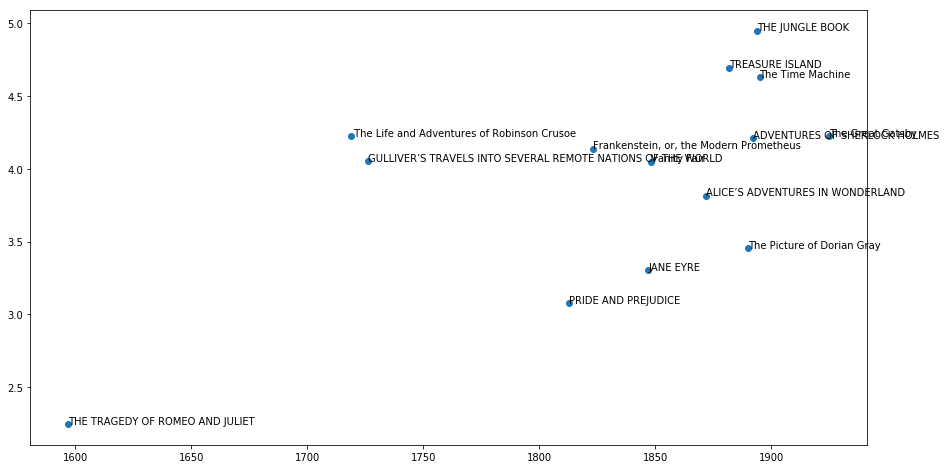

In [11]:
fig, ax = plt.subplots()
ax.scatter(years, scores)

for i, txt in enumerate(labels):
    ax.annotate(txt, (years[i], scores[i]))

What can we see from the figure? As one would expect, Shakespeare's "The Tragedy of Romeo and Juliet" has a relatively low score, so it appears to be less convenient for reading and understanding. Kipling's "The Jungle Book" has the highest score, and no surprise this book is one of all-time favourites for old and, especially, young. Well, at leat, here in Russia.  
  
Finally, we can see that some earlier books like "The Life and Adventures of Robinson Crusoe" and "Frankenstein, or, The Modern Prometheus" have higher scores compared to latter ones like "Pride and Prejustice" or "Alice's Adventures in Wonderland". This might look quite surprising, as one would expect that texts' "modernity" increases over time quite monotonically.

## Rare words counting

Another scoring technique we'll apply is to check how many words that are not listed among the most frequent does the text contain. To make this metric less sensitive to text length, we'll take a fraction of these rare words. The idea here is also simple and straightforward: the more rare words the text includes, the less "modern" it is. Note that, contrary to the average metric we considered, the higher this score is, the less modern the text is.

In [12]:
def rares_fraction_scorer(tokens):
    """
    Modernity scorer that calculates fraction of words that are not
    listed among the most frequent
    Args:
        tokens (iterable): tokens to be evaluated
    """
    num_tokens = len(list(tokens))
    rares = set(tokens) - set(word_count_df.index)
    score = len(rares) / num_tokens
    return score

In [13]:
results = []
for book in books_index:
    with open(f"./books/{book['file_name']}.txt", 'rt', encoding='utf8') as f:
        text = f.read()
        score = evaluate_text(text, rares_fraction_scorer)
        results.append({
            'book': book,
            'score': score
        })

In [15]:
years = [r['book']['year'] for r in results]
scores = [r['score'] * 10000 for r in results]
labels = [r['book']['title'] for r in results]

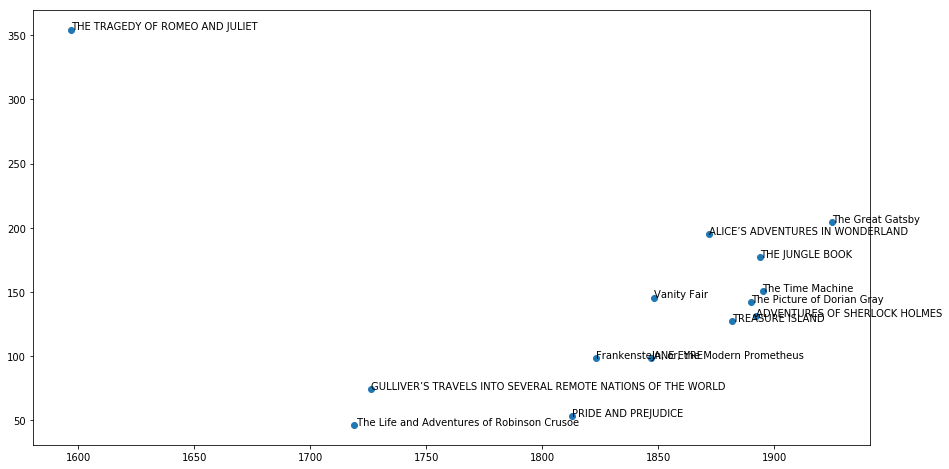

In [16]:
fig, ax = plt.subplots()
ax.scatter(years, scores)

for i, txt in enumerate(labels):
    ax.annotate(txt, (years[i], scores[i]))

Again, we see from the picture that "Romeo and Juliet" differs from other texts significally as it has a relatively high fraction of rare words. "The Jugle Book" that was our winner in the previous test, is now among the outsiders as it has a higher rate of rare words compared to most of other texts even those that are older.  
  
Also there is a clear tendency that tha rare words rate increases over time. This is quite surprising as one would expect an opposide tendency. This might be a real-word tendency or a 